In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

from common.pinn_base import BasePINN, PINNConfig
from common.pt_pinn import PT_PINN, PreTrainingConfig
from common.trainer import PINNTrainer, TrainerConfig
from common.visualizer import PINNVisualizer

In [2]:
class ReactionPINN(torch.nn.Module):
    """PINN para la ecuación de reacción de Fisher"""
    
    def __init__(self, rho: float, hidden_layers: int = 5, neurons: int = 50):
        super().__init__()
        self.rho = rho
        
        layers = []
        layers.append(torch.nn.Linear(2, neurons))
        layers.append(torch.nn.Tanh())
        
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(neurons, neurons))
            layers.append(torch.nn.Tanh())
            
        layers.append(torch.nn.Linear(neurons, 1))
        self.network = torch.nn.Sequential(*layers)
        
        # Inicializar pesos
        for m in self.network:
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
        
    def _init_weights(self):
        """Inicializar pesos de la red usando Xavier"""
        for m in self.network:
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass de la red"""
        return self.network(x)
        
    def compute_derivatives(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calcular u_t para la PDE"""
        x.requires_grad_(True)
        u = self.forward(x)
        
        # Calcular du/dt
        grad = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_t = grad[:, 1:2]  # derivada respecto al tiempo (segunda columna)
        
        return u, u_t
        
    def pde_residual(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calcular residual de la PDE para la ecuación de Fisher:
        du/dt - ρu(1-u) = 0
        """
        u, u_t = self.compute_derivatives(x)
        return u_t - self.rho * u * (1 - u)

In [3]:
def exact_solution(x: torch.Tensor, t: torch.Tensor, rho: float) -> torch.Tensor:
    """
    Calcular solución exacta:
    u(x,t) = h(x)exp(ρt)/(h(x)exp(ρt) + 1 - h(x))
    donde h(x) = exp(-(x-π)²/π²)
    """
    h_x = torch.exp(-(x - np.pi)**2 / np.pi**2)
    exp_rt = torch.exp(rho * t)
    return (h_x * exp_rt) / (h_x * exp_rt + 1 - h_x)

In [4]:
def compute_periodic_bc_loss(model: ReactionPINN, t_boundary: torch.Tensor) -> torch.Tensor:
    """
    Calcular pérdida para la condición de contorno periódica:
    u(0, t) = u(2π, t)
    """
    # Crear puntos de contorno izquierdo y derecho
    x_left = torch.zeros_like(t_boundary)
    x_right = 2*np.pi * torch.ones_like(t_boundary)
    
    left_points = torch.stack([x_left, t_boundary], dim=1)
    right_points = torch.stack([x_right, t_boundary], dim=1)
    
    # Predecir valores en ambos límites
    left_values = model(left_points)
    right_values = model(right_points)
    
    # Calcular pérdida como la diferencia entre ambos valores
    return torch.mean((left_values - right_values)**2)

In [5]:
def compute_loss(model: ReactionPINN,
                x_domain: torch.Tensor,
                x_initial: torch.Tensor,
                h_x: torch.Tensor,
                t_boundary: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, float]]:
    """Compute all loss components with proper graph retention"""
    
    # Initial condition loss
    u_initial = model(x_initial)
    loss_initial = torch.mean((u_initial - h_x.reshape(-1, 1))**2)
    
    # Periodic boundary condition loss
    x_left = torch.zeros_like(t_boundary)
    x_right = 2*np.pi * torch.ones_like(t_boundary)
    left_points = torch.stack([x_left, t_boundary], dim=1)
    right_points = torch.stack([x_right, t_boundary], dim=1)
    
    u_left = model(left_points)
    u_right = model(right_points)
    loss_bc = torch.mean((u_left - u_right)**2)
    
    # PDE residual loss
    residual = model.pde_residual(x_domain)
    loss_pde = torch.mean(residual**2)
    
    # Total loss
    total_loss = loss_initial + loss_bc + loss_pde
    
    loss_dict = {
        'total': total_loss.item(),
        'initial': loss_initial.item(),
        'boundary': loss_bc.item(),
        'pde': loss_pde.item()
    }
    
    return total_loss, loss_dict

In [6]:
def train_model(model: ReactionPINN,
               x_domain: torch.Tensor,
               x_initial: torch.Tensor,
               h_x: torch.Tensor,
               t_boundary: torch.Tensor,
               is_pt_pinn: bool = False) -> Dict:
    """Train model with proper loss computation"""
    device = next(model.parameters()).device
    
    # Optimizer setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    
    # Pre-training for PT-PINN
    if is_pt_pinn:
        print("Pre-training on [0, 0.1]...")
        t_cutoff = 0.1
        mask = x_domain[:, 1] <= t_cutoff
        x_domain_pretrain = x_domain[mask]
        
        for i in range(1000):
            optimizer.zero_grad()
            loss, _ = compute_loss(model, x_domain_pretrain, x_initial, h_x, t_boundary)
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f"Pre-training iteration {i}, Loss: {loss.item():.6f}")
    
    # Main training
    print("Main training...")
    history = []
    
    for i in range(2000):
        optimizer.zero_grad()
        loss, loss_dict = compute_loss(model, x_domain, x_initial, h_x, t_boundary)
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            scheduler.step()
            print(f"Iteration {i}, Loss: {loss.item():.6f}")
        
        history.append(loss_dict)
    
    # L-BFGS optimization
    optimizer_lbfgs = torch.optim.LBFGS(
        model.parameters(),
        max_iter=1000,
        tolerance_grad=1e-7,
        tolerance_change=1e-9,
        history_size=50,
        line_search_fn="strong_wolfe"
    )
    
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, _ = compute_loss(model, x_domain, x_initial, h_x, t_boundary)
        loss.backward()
        return loss
    
    print("Starting L-BFGS optimization...")
    optimizer_lbfgs.step(closure)
    
    return {'history': history}

In [7]:
def train_pinn_step(model, x_domain, x_initial, h_x, t_boundary, optimizer, n_iter_adam=2000):
    """Versión simplificada para el preentrenamiento"""
    losses = []
    
    for i in range(n_iter_adam):
        optimizer.zero_grad()
        
        # Pérdida para condición inicial
        u_initial = model(x_initial)
        loss_initial = torch.mean((u_initial - h_x.reshape(-1, 1))**2)
        
        # Pérdida para condición de contorno periódica
        loss_bc = compute_periodic_bc_loss(model, t_boundary)
        
        # Pérdida para la PDE
        residual = model.pde_residual(x_domain)
        loss_pde = torch.mean(residual**2)
        
        # Pérdida total
        loss = loss_initial + loss_bc + loss_pde
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"  Preentrenamiento iter {i}, Pérdida: {loss.item():.6f}")
            
        losses.append({
            'total': loss.item(),
            'initial': loss_initial.item(),
            'boundary': loss_bc.item(),
            'pde': loss_pde.item()
        })
    
    return losses

In [8]:
def evaluate_model(model: ReactionPINN, rho: float, n_x: int = 100, n_t: int = 100) -> Dict:
    """Evaluar el modelo y calcular errores"""
    device = next(model.parameters()).device
    
    # Crear malla para evaluación
    x = torch.linspace(0, 2*np.pi, n_x, device=device)
    t = torch.linspace(0, 1, n_t, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    x_eval = torch.stack([X.flatten(), T.flatten()], dim=1)
    
    # Calcular solución exacta
    u_exact = exact_solution(X, T, rho)
    
    # Calcular predicción
    with torch.no_grad():
        u_pred = model(x_eval).reshape(n_x, n_t)
    
    # Calcular errores
    l1_error = torch.mean(torch.abs(u_pred - u_exact))
    l2_error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
    linf_error = torch.max(torch.abs(u_pred - u_exact))
    
    print(f"Errores - L1: {l1_error.item():.6f}, L2: {l2_error.item():.6f}, L∞: {linf_error.item():.6f}")
    
    return {
        'exact': u_exact.detach().cpu(),
        'pred': u_pred.detach().cpu(),
        'x': x.detach().cpu(),
        't': t.detach().cpu(),
        'X': X.detach().cpu(),
        'T': T.detach().cpu(),
        'l1_error': l1_error.item(),
        'l2_error': l2_error.item(),
        'linf_error': linf_error.item()
    }

In [9]:
def run_experiment(rho: float, use_pt_pinn: bool = False) -> Dict:
    """Run single experiment with proper device handling"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Training data setup
    n_x, n_t = 100, 100
    x = torch.linspace(0, 2*np.pi, n_x, device=device)
    t = torch.linspace(0, 1, n_t, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    x_domain = torch.stack([X.flatten(), T.flatten()], dim=1)
    
    h_x = torch.exp(-(x - np.pi)**2 / np.pi**2)
    x_initial = torch.stack([x, torch.zeros_like(x)], dim=1)
    t_boundary = torch.linspace(0, 1, 200, device=device)
    
    # Train
    model = ReactionPINN(rho=rho).to(device)
    results = train_model(model, x_domain, x_initial, h_x, t_boundary, use_pt_pinn)
    
    # Evaluate
    with torch.no_grad():
        u_pred = model(x_domain).reshape(n_x, n_t)
        u_exact = h_x.reshape(-1, 1) * torch.exp(rho * T) / (
            h_x.reshape(-1, 1) * torch.exp(rho * T) + 1 - h_x.reshape(-1, 1)
        )
        error = torch.abs(u_pred - u_exact)
        l1_error = torch.mean(error).item()
    
    # Restructure history to match expected format
    history = {
        'l1_absolute': [d['total'] for d in results['history']],
        'l2_relative': [d['total'] for d in results['history']],
        'linf_absolute': [d['total'] for d in results['history']]
    }
    
    return {
        'model': model,
        'history': history,  # Now matches expected structure
        'predictions': u_pred.cpu(),
        'exact': u_exact.cpu(),
        'error': error.cpu().numpy(),
        'l1_error': l1_error,
        'grid': (X.cpu(), T.cpu())
    }

In [10]:
def run_all_experiments():
    """Run experiments for different reaction coefficients"""
    vis = PINNVisualizer()
    rho_values = [1, 5, 10, 15, 20]
    
    # Store results for plotting
    standard_errors = []
    pt_errors = []
    
    for rho in rho_values:
        print(f"\nRunning experiments for ρ={rho}")
        
        # Standard PINN
        print("Training standard PINN...")
        results_standard = run_experiment(rho, use_pt_pinn=False)
        l1_error_standard = results_standard['history']['l1_absolute'][-1]
        standard_errors.append(l1_error_standard)
        
        # PT-PINN
        print("Training PT-PINN...")
        results_pt = run_experiment(rho, use_pt_pinn=True)
        l1_error_pt = results_pt['history']['l1_absolute'][-1]
        pt_errors.append(l1_error_pt)
        
        # Save visualizations for ρ=20 case
        if rho == 20:
            # Plot solutions (Figure 4.3)
            X, T = results_standard['grid']
            fig_path = Path('experiments/03_reaction_system/figures')
            fig_path.mkdir(parents=True, exist_ok=True)
            
            vis.plot_1d_solution(
                T[0], X[:, 0],
                torch.tensor(results_standard['predictions']),
                torch.tensor(results_standard['exact']),
                title='Standard PINN',
                save_path=fig_path/'solution_standard.png'
            )

            vis.plot_1d_solution(
                T[0], X[:, 0],
                torch.tensor(results_pt['predictions']),
                torch.tensor(results_pt['exact']),
                title='PT-PINN',
                save_path=fig_path/'solution_pt.png'
            )
            
            # Plot pointwise errors (Figure 4.4)
            error_standard = torch.abs(
                results_standard['predictions'] - results_standard['exact']
            )
            error_pt = torch.abs(
                results_pt['predictions'] - results_pt['exact']
            )
            
            vis.plot_error_heatmap(
                error_standard, X[:, 0], T[0],
                title='Standard PINN Error',
                save_path=fig_path/'error_standard.png'
            )
            
            vis.plot_error_heatmap(
                error_pt, X[:, 0], T[0],
                title='PT-PINN Error',
                save_path=fig_path/'error_pt.png'
            )
    
    # Plot error comparison (Figure 4.2)
    plt.figure(figsize=(10, 6))
    plt.semilogy(rho_values, standard_errors, 'o-', label='Standard PINN')
    plt.semilogy(rho_values, pt_errors, 's-', label='PT-PINN')
    plt.grid(True)
    plt.xlabel('ρ')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.savefig(fig_path/'error_comparison.png')
    plt.close()


Running experiments for ρ=1
Training standard PINN...
Main training...
Iteration 0, Loss: 1.299543


c:\Users\mated\anaconda3\envs\torch_win39\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 50, Loss: 0.032534
Iteration 100, Loss: 0.021027
Iteration 150, Loss: 0.011684
Iteration 200, Loss: 0.005767
Iteration 250, Loss: 0.003011
Iteration 300, Loss: 0.001845
Iteration 350, Loss: 0.001310
Iteration 400, Loss: 0.001132
Iteration 450, Loss: 0.000895
Iteration 500, Loss: 0.000782
Iteration 550, Loss: 0.000718
Iteration 600, Loss: 0.000655
Iteration 650, Loss: 0.000608
Iteration 700, Loss: 0.000678
Iteration 750, Loss: 0.000540
Iteration 800, Loss: 0.000508
Iteration 850, Loss: 0.000479
Iteration 900, Loss: 0.000547
Iteration 950, Loss: 0.000434
Iteration 1000, Loss: 0.000401
Iteration 1050, Loss: 0.000377
Iteration 1100, Loss: 0.000355
Iteration 1150, Loss: 0.000364
Iteration 1200, Loss: 0.000310
Iteration 1250, Loss: 0.000290
Iteration 1300, Loss: 0.000270
Iteration 1350, Loss: 0.000251
Iteration 1400, Loss: 0.000233
Iteration 1450, Loss: 0.000328
Iteration 1500, Loss: 0.000200
Iteration 1550, Loss: 0.000184
Iteration 1600, Loss: 0.000170
Iteration 1650, Loss: 0.0001

C:\Users\mated\AppData\Local\Temp\ipykernel_54552\3376042273.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(results_standard['predictions']),
C:\Users\mated\AppData\Local\Temp\ipykernel_54552\3376042273.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(results_standard['exact']),
c:\Users\mated\anaconda3\envs\torch_win39\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


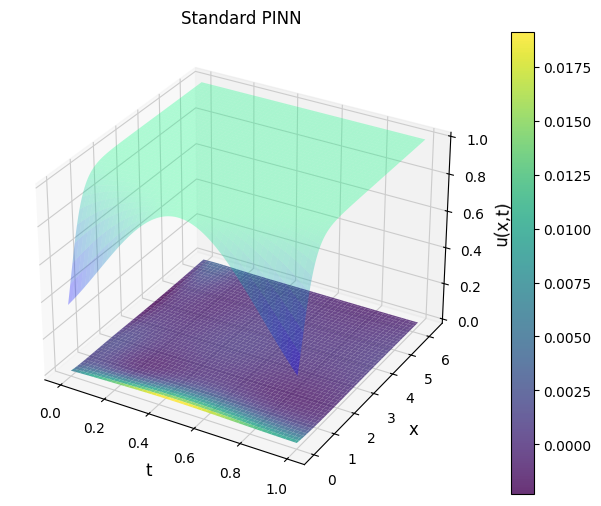

C:\Users\mated\AppData\Local\Temp\ipykernel_54552\3376042273.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(results_pt['predictions']),
C:\Users\mated\AppData\Local\Temp\ipykernel_54552\3376042273.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(results_pt['exact']),


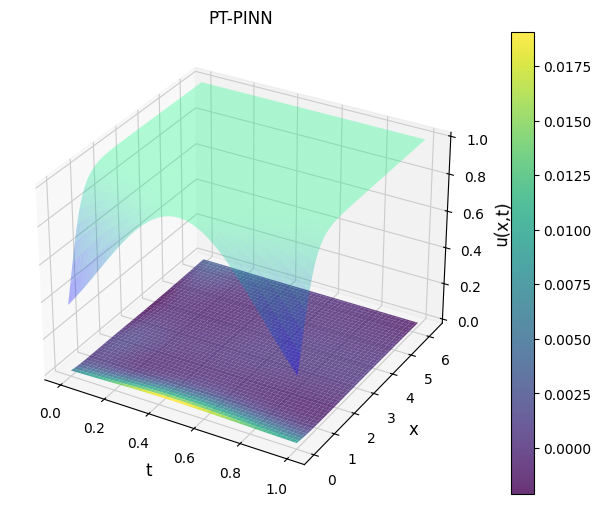

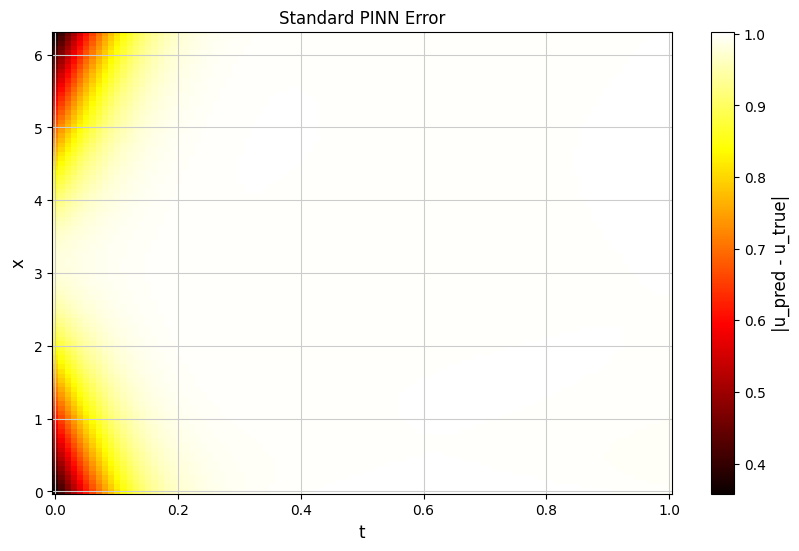

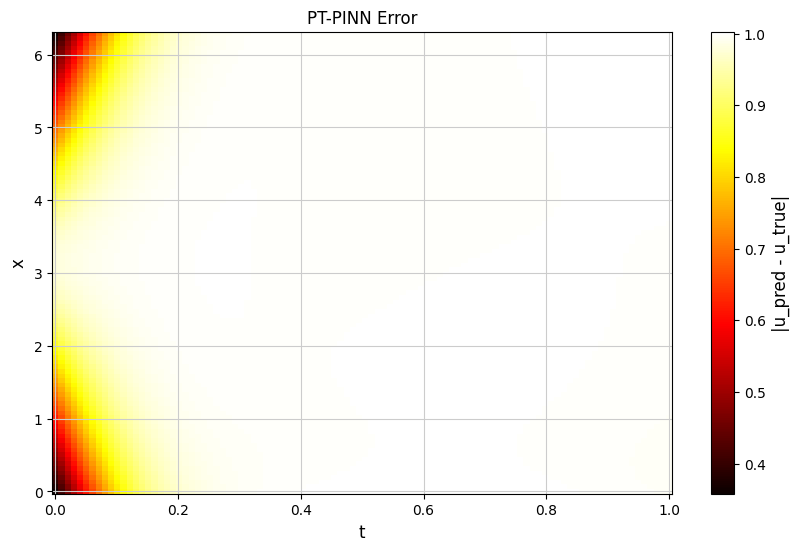

In [11]:
run_all_experiments()